# Intel Geti Tech Experience Demo - Intel Innovation 2023

## Serving Geti model(s) with OpenVINO Model Server

In this notebook, we will show how to run the deployment of an Intel Geti model selecting a OVMS service or this local machine. You will have the posibility to select how you want to see the inference in action. Ask one of our demo staffers to help you putting your geti model in the OpenVINO Model Server we have available for you. 

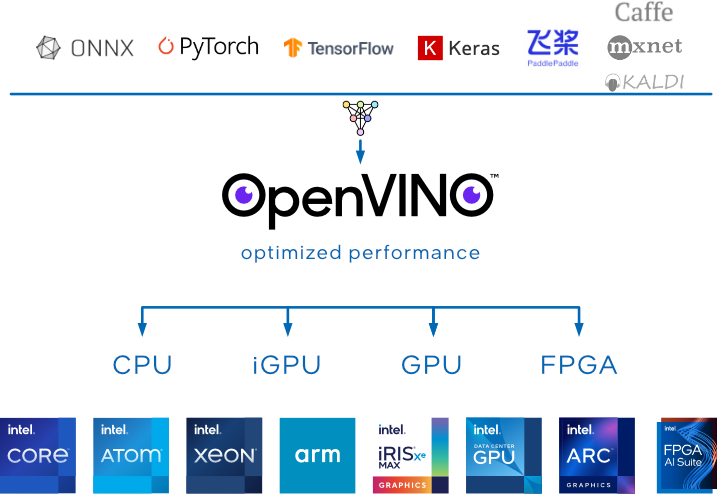

In [2]:
# As usual we will connect to the platform first, using the server details from the .env file

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env()

geti = Geti(server_config=geti_server_configuration)

2023-08-23 09:57:46,788 - INFO - Authenticating on host https://192.168.0.175...
2023-08-23 09:57:46,860 - INFO - Authentication successful. Cookie received.


C:\Users\pjram\geti_env\lib\site-packages\geti_sdk\http_session\geti_session.py:71: InsecureRequestWarning: You have disabled TLS certificate validation, HTTPS requests made to the Intel® Geti™ server may be compromised. For optimal security, please enable certificate validation.
  warnings.warn(


### Selecting a project for OVMS deployment
Let's list all projects in the workspace and select one for which to create a deployment

In [3]:
from geti_sdk.rest_clients import ProjectClient

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)
projects = project_client.list_projects()

4 projects were found on the platform:

 Project: Cubes_ObjectDetection
  Task 1: Detection task
    Labels: ['No Object', 'Defect']


 Project: Cubes_Classification
  Task 1: Classification task
    Labels: ['Good', 'Bad']


 Project: Cube_AnomalyClass
  Task 1: Anomaly classification task
    Labels: ['Normal', 'Anomalous']


 Project: person-bike-car
  Task 1: Detection task
    Labels: ['person', 'car', 'bike', 'No Object']




In [34]:
PROJECT_NAME = "Cubes_ObjectDetection"

Before deploying, we need to make sure that the project is trained. Otherwise it will not contain any models to deploy, and the deployment will fail.

> NOTE: If the `COCO animal detection demo` project does not exist on your Geti server, you can either create it by running notebook [002](002_create_project_from_dataset.ipynb), or select a different project to deploy by changing the `PROJECT_NAME` variable above.

## Inference with OVMS

Once you have the server running we will use 

In [35]:
from geti_sdk.demos import ensure_trained_example_project

ensure_trained_example_project(geti=geti, project_name=PROJECT_NAME);

2023-08-23 13:17:53,890 - INFO - Authentication may have expired, re-authenticating...
2023-08-23 13:17:54,016 - INFO - Authentication complete.

Project 'Cubes_ObjectDetection' is ready to predict.



Once we are sure that the project has trained models for each task, we can create the deployment in the cell below. Note the `prepare_ovms_config=True` argument which indicates that the model configuration for OVMS will be created.

In [36]:
import os

from pathvalidate import sanitize_filepath

# We'll create a directory with the name of the project to save the deployment to, so we have
# to make sure that the project name can act as folder name.
safe_project_name = sanitize_filepath(PROJECT_NAME).replace(" ", "_")

# Target folder in which to save the deployment and OVMS configuration
output_folder = os.path.join("deployments", safe_project_name)

# Create the deployment and OVMS configuration, and save it to the `output_folder` on disk
deployment = geti.deploy_project(
    project_name=PROJECT_NAME, prepare_ovms_config=True, output_folder=output_folder
)

2023-08-23 13:17:57,434 - INFO - Deployment for project 'Cubes_ObjectDetection' started.
2023-08-23 13:17:57,443 - INFO - Waiting for the deployment to be created...
2023-08-23 13:17:59,596 - INFO - Downloading project deployment archive...
2023-08-23 13:17:59,723 - INFO - Deployment for project 'Cubes_ObjectDetection' downloaded and extracted successfully.
2023-08-23 13:18:01,450 - INFO - Configuration files for OVMS model deployment have been generated in directory 'deployments\Cubes_ObjectDetection'. This folder contains a `OVMS_README.md` file with instructions on how to launch OVMS, connect to it and run inference. Please follow the instructions outlined there to get started.


## Making inference requests to OVMS
### Connecting to OVMS
Now that everything is set up and ready, we can connect the deployment we created earlier to the OVMS container that we got running. This is done in the cell below

In [37]:
deployment.load_inference_models(device="http://192.168.0.174:9000") #"http://localhost:9000")

2023-08-23 13:18:09,063 - INFO - Connecting to remote model: 192.168.0.174:9000/models/cubes_objectdetection_atss_openvino_fp16
2023-08-23 13:18:09,140 - WARNING - The parameter "result_based_confidence_threshold" not found in OTX_SSD wrapper, will be omitted
2023-08-23 13:18:09,141 - WARNING - The parameter "use_ellipse_shapes" not found in OTX_SSD wrapper, will be omitted
2023-08-23 13:18:09,141 - INFO - Inference models loaded on device `http://192.168.0.174:9000` successfully.


## Running inference on an image
Now, we can load an image as a numpy array (for instance using OpenCV) and use the `deployment.infer` method to generate a prediction for it.
The SDK contains an example image that we use for this. The path to the image is in the `EXAMPLE_IMAGE_PATH` constant, from the `geti_sdk.demos` module.

If you have worked through notebook [008](008_deploy_project.ipynb) you'll notice that the API for local inference or OVMS inference is exactly the same. The only difference being the target for loading the inference models.

In [42]:
import time

import cv2

from geti_sdk.demos import EXAMPLE_IMAGE_PATH

#numpy_image = cv2.imread(EXAMPLE_IMAGE_PATH)
numpy_image = cv2.imread("C:/Users/pjram/Downloads/cubes/cubes/abnormal/input_20230210134128.jpg")

# Convert to RGB channel order. All deployed models expect the image in RGB format
numpy_rgb = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

t_start = time.time()
prediction = deployment.infer(numpy_rgb)
t_elapsed = time.time() - t_start

print(f"Running OVMS inference on image took {t_elapsed*1000:.2f} milliseconds")

Running OVMS inference on image took 489.61 milliseconds


### Inspecting the result
The `Prediction` object generated by `deployment.infer` is equal in structure to the predictions sent by the platform. So let's have a closer look at it. We can do so in two ways: 

1. Visualise it using the `show_image_with_annotation_scene` utility function
2. Inspecting its properties via the `prediction.overview` property

Let's show it on the image first

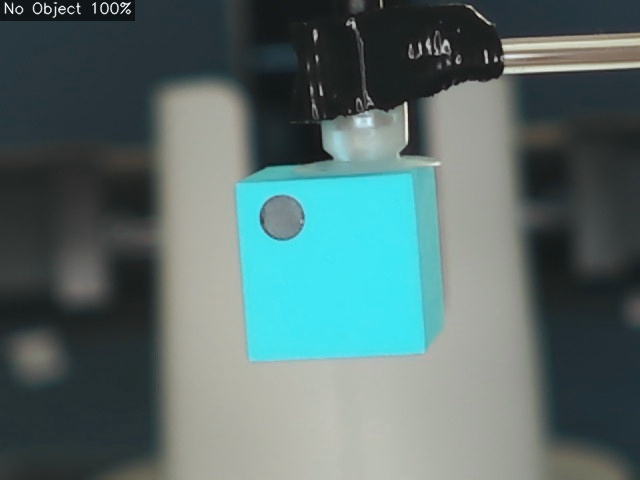

In [43]:
from geti_sdk.utils import show_image_with_annotation_scene

show_image_with_annotation_scene(numpy_image, prediction, show_in_notebook=True);

# *********** Pending for reviewing  ***************

## Switching to local deployment
Of course, we can still use the deployment to load the models locally on the client. That can be done simply by calling `deployment.load_inference_models` again, this time specifying a different device (for example `CPU` or `GPU`).

In [44]:
deployment.load_inference_models(device="GPU.1")

2023-08-23 13:19:26,101 - INFO - OpenVINO Runtime
2023-08-23 13:19:26,101 - INFO - 	build: 2022.3.0-9052-9752fafe8eb-releases/2022/3
2023-08-23 13:19:26,103 - INFO - Reading model deployments\Cubes_ObjectDetection\deployment\Detection task\model\model.xml
2023-08-23 13:19:26,411 - WARNING - The parameter "result_based_confidence_threshold" not found in OTX_SSD wrapper, will be omitted
2023-08-23 13:19:26,413 - WARNING - The parameter "use_ellipse_shapes" not found in OTX_SSD wrapper, will be omitted
2023-08-23 13:19:46,997 - INFO - The model deployments\Cubes_ObjectDetection\deployment\Detection task\model\model.xml is loaded to GPU.1
2023-08-23 13:19:46,998 - INFO - 	Number of model infer requests: 1
2023-08-23 13:19:47,000 - INFO - Inference models loaded on device `GPU.1` successfully.


In [45]:
t_start = time.time()
prediction = deployment.infer(numpy_rgb)
t_elapsed = time.time() - t_start

print(f"Running local inference on image took {t_elapsed*1000:.2f} milliseconds")

Running local inference on image took 86.95 milliseconds


Notice that the code to run inference is exactly the same, whether it uses OVMS or loads the models directly to the CPU. 

## Benchmarking inference times

You might have noticed that there is a difference in execution time due to the overhead introduced by OVMS. Let's do some benchmarking to further investigate the difference.

First, we measure the execution time for running inference on CPU locally:

In [46]:
%%timeit -n 10 -r 3

# CPU inference
prediction = deployment.infer(numpy_rgb)

50.8 ms ± 2.06 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Now switch to OVMS and run the benchmark again:

In [47]:
deployment.load_inference_models(device="http://192.168.0.174:9000")

2023-08-23 13:20:08,472 - INFO - Connecting to remote model: 192.168.0.174:9000/models/cubes_objectdetection_atss_openvino_fp16
2023-08-23 13:20:08,491 - WARNING - The parameter "result_based_confidence_threshold" not found in OTX_SSD wrapper, will be omitted
2023-08-23 13:20:08,493 - WARNING - The parameter "use_ellipse_shapes" not found in OTX_SSD wrapper, will be omitted
2023-08-23 13:20:08,629 - INFO - Inference models loaded on device `http://192.168.0.174:9000` successfully.


In [48]:
%%timeit -n 10 -r 3

# OVMS inference
prediction = deployment.infer(numpy_rgb)

453 ms ± 10.6 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


For the single task `COCO animal detection demo` project, OVMS inference introduces some overhead (the exact amount is depending on the hardware configuration of your system). Note that this does not include any network traffic yet, because OVMS is running on your local system as well: Running OVMS on a remote server will introduce additional overhead.

# Conclusion
That's it! This notebook should provide a handle on how to deploy and serve models created with the Intel® Geti™ platform. 

The OVMS configuration files created in this notebook can be used independently: They just need to be provided to the OVMS docker container upon startup. This is useful when you aim to deploy a remote OVMS instance. 